# HW6: Machine learning

**Due Wednesday April 6, 8pm**

Margaret Doyle
mddoyle@lbl.gov

(AY250 2022)

# #1 Load Data

In [2]:
!curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200M  100  200M    0     0  7009k      0  0:00:29  0:00:28  0:00:01 10.3Mk    0     0   814k      0  0:04:11  0:00:03  0:04:08  814k 1238k      0  0:02:45  0:00:07  0:02:38 1518k0:29  0:00:29 --:--:-- 10.4M


In [2]:
import h5py
import numpy as np
from tensorflow.keras import utils

# # To get the images and labels from file
with h5py.File('/Users/yyk_lab/Downloads/ay250-hw/python-ay250-homework/python-seminar/Homeworks/hw_6/galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# # Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# # Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


# #2 Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

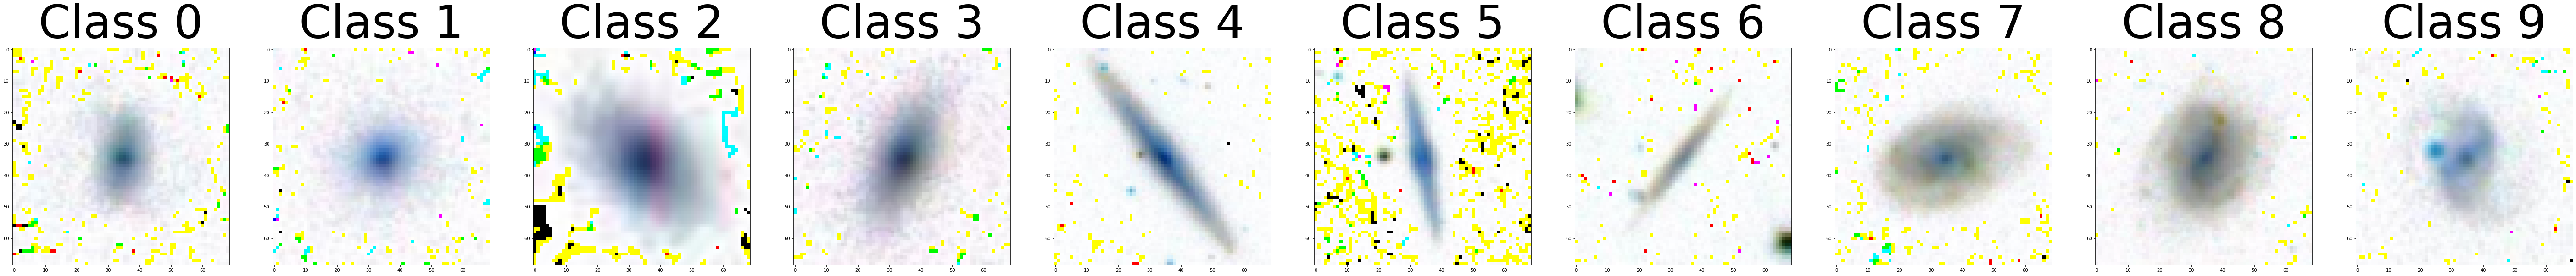

In [6]:
import matplotlib.pyplot as plt 
import random
fig, axs = plt.subplots(1,10, figsize=[100,100])

#Will use this for histogram later 
sorted_by_class=[]

#Loop over all 10 classes... 
for i, ax in enumerate(axs.flatten()):
    labels_filtered = []
    images_filtered=[]
    
    for x in range(0,len(labels)):
        if labels[x].argmax() ==i:   # Focus on one class at a time 
            labels_filtered.append(labels[x]) #Filter images and labels 
            images_filtered.append(images[x])
            sorted_by_class.append(i) #Append class type so we can look at distribution later 
            
    random.seed(0) 
    a =random.randint(0,(np.array(labels_filtered).shape[0]))
    ax.imshow((images_filtered[a]* 255).astype(np.uint8) )
    ax.set_title("Class %d" %np.argmax(labels_filtered[a]), fontsize=100)


# #3 Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

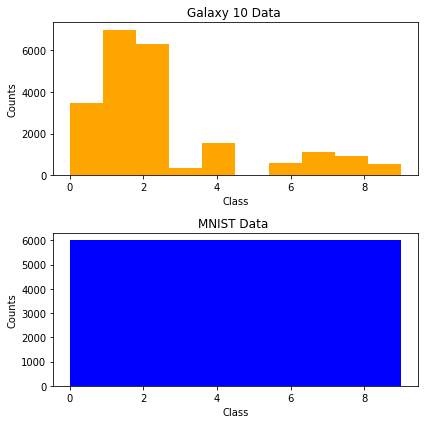

In [7]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

fig, ax = plt.subplots(2,1, figsize=[6,6])
ax[0].hist(sorted_by_class, color='orange', bins=10)
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Counts')
ax[0].set_title('Galaxy 10 Data ')

ax[1].hist(y_train, color='blue', bins=10)
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Counts')
ax[1].set_title('MNIST Data ')

plt.tight_layout()



##  My Comment: MNIST Data is much more evenly distributed across the different classes, so all should be predicted with a similar level of accuracy. Galaxy 10 data has more data for classes 1 and 2, so I assume those will be prediected way easier. Class 5 really appears to be lacking in data.

# #3 Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

In [8]:
from sklearn.model_selection import train_test_split

#Split into train and test set with random seed. 80% of data will go towards training. 
x_train,x_test = train_test_split(np.arange(0,len(labels)), train_size=0.80,  random_state = 0)
train_images = images[x_train]
train_labels = labels[x_train]

test_images = images[x_test]
test_labels = labels[x_test]

#We have 20% of the data left to split into test and validation 
y_valid, y_test, x_valid, x_test = train_test_split(test_labels,test_images, test_size=0.5, random_state = 0)

print ("x_train shape: ", train_images.shape)
print ("y_train shape: ", train_labels.shape)
print('***')
print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)
print('***')
print ("x_valid shape:  ", x_valid.shape)
print ("y_valid shape:  ", y_valid.shape)
#My input layer has dimensions 69x69x3, my output layer has dimensions 10

x_train shape:  (17428, 69, 69, 3)
y_train shape:  (17428, 10)
***
x_test shape:   (2179, 69, 69, 3)
y_test shape:   (2179, 10)
***
x_valid shape:   (2178, 69, 69, 3)
y_valid shape:   (2178, 10)


In [9]:
from keras.models import Sequential
from keras.layers import Conv3D
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization
)
from tensorflow.keras.layers import Dense, Dropout, Flatten
import keras
from keras.models import Model
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import categorical_crossentropy
from keras import utils
from tensorflow.keras.utils import to_categorical
import tensorflow
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization
)

#Input layer is 69x69x3 images
input_lay = Input((69,69, 3))

#Will use 2D Conv since I only have 2 spatial dimensions. And increase filter size in steps. 
lay1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_lay)
lay2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(lay1)
pool_lay1 = MaxPooling2D(pool_size=(2, 2))(lay2)
lay3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pool_lay1)
lay4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(lay3)
pool_lay2 = MaxPooling2D(pool_size=(2, 2))(lay4)

#Next, apply batch normalization 
pool_lay2 = BatchNormalization()(pool_lay2)
flatten_layer = Flatten()(pool_lay2)

#Adding dense layers 
dense_lay1 = Dense(64)(flatten_layer)
dense_lay2 = Dense(32)(dense_lay1)
output_layer= Dense(10,activation='softmax')(dense_lay2)


model = Model(inputs=input_lay, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69, 69, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 67, 67, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 16)        1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                             

# #4 Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

In [11]:
import datetime, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
model_path = f'nn_results/ay250_nn_{run_time_string}.h5'
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#Early stopping
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, 
                                             patience=3, \
                                             verbose=1, mode='auto')
model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

#Learning rate decay 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.7,
                              patience=2, min_lr=1e-5, verbose=1, cooldown=0)


model.fit(x=train_images, y=train_labels,batch_size=128, epochs=50, validation_split=0.2, validation_data = ( x_valid,  y_valid), callbacks =[earlystop, model_check, reduce_lr  ])
x_train.shape

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.5720 - accuracy: 0.4802
Epoch 1: val_accuracy improved from -inf to 0.35427, saving model to nn_results/ay250_nn_2022-04-07T02:02.h5
109/109 [==============================] - 47s 423ms/step - loss: 1.5720 - accuracy: 0.4802 - val_loss: 2.0648 - val_accuracy: 0.3543 - lr: 0.0010
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 1.0961 - accuracy: 0.5588
Epoch 2: val_accuracy improved from 0.35427 to 0.40993, saving model to nn_results/ay250_nn_2022-04-07T02:02.h5
109/109 [==============================] - 44s 406ms/step - loss: 1.0961 - accuracy: 0.5588 - val_loss: 1.5345 - val_accuracy: 0.4099 - lr: 0.0010
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 1.0005 - accuracy: 0.6024
Epoch 3: val_accuracy improved from 0.40993 to 0.56799, saving model to nn_results/ay250_nn_2022-04-07T02:02.h5
109/109 [==============================] - 52s 482ms/step - loss: 1.0005 - accuracy: 

(17428,)

# #5 Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

In [13]:
import pandas as pd
from tensorflow.keras.models import load_model

latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
model = load_model(latest_model_file[0])

pred_y = model.predict(test_images)


# My Comment: My model ended up having  66% val_accuracy. Next, I will look at an individual case as well as a confusion matrix.

Predicted: Round Smooth Galaxies
Real: Round Smooth Galaxies


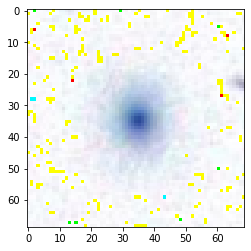

Predicted: Unbarred Loose Spiral Galaxies
Real: Unbarred Loose Spiral Galaxies


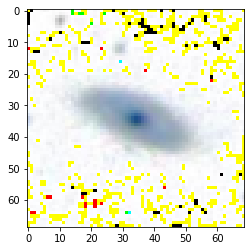

In [19]:
class_names = ['Disturbed Galaxies', 'Merging Galaxies', 'Round Smooth Galaxies', 
               'In-between Round Smooth Galaxies',  'Cigar Shaped Smooth Galaxies', 'Barred Spiral Galaxies', 
               'Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies', 'Edge-on Galaxies without Bulge', 
            'Edge-on Galaxies with Bulge']

ind = 690
plt.figure()
plt.imshow((x_test[ind]* 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')
print("Predicted:", class_names[np.argmax(pred_y[ind])])
print("Real:" ,class_names[np.argmax(test_labels[ind])])
plt.show()

ind =1000
plt.figure()
plt.imshow((x_test[ind]* 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')
print("Predicted:", class_names[np.argmax(pred_y[ind])])
print("Real:" ,class_names[np.argmax(test_labels[ind])])



/Users/yyk_lab/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(33.0, 0.5, 'True class')

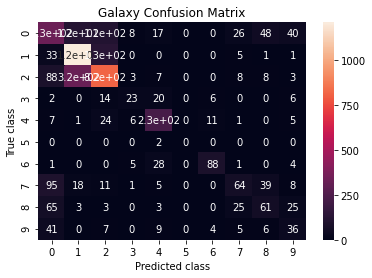

In [20]:
import seaborn as sns
matrix = confusion_matrix(np.argmax(test_labels, axis=1) , np.argmax(pred_y, axis=1))
sns.heatmap(matrix, annot=True)
plt.title('Galaxy Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')


# My Comment: This model helped predict Class 0,1,2,4 images. The network was very poor with class 5. Class 7 was confused for class 0 quite a bit. The discrepancy is likely a result of the inhomogeneous distribution of data. 

# #6 Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

In [49]:
from tensorflow.keras import layers
#Will rotate image and rescale
augmentation = tf.keras.Sequential([layers.Rescaling(0.5),layers.RandomFlip(mode='vertical') ])

augmented_images = []
for x in train_images:
    augmented_images.append(augmentation(x))

print(type(augmented_images), type(train_images))

<class 'list'> <class 'numpy.ndarray'>


In [50]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.fit(x=np.array(augmented_images), y=train_labels,batch_size=128, epochs=50, validation_split=0.2, validation_data = ( x_valid,  y_valid), callbacks =[earlystop, model_check, reduce_lr  ])


Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.7896
Epoch 1: val_accuracy did not improve from 0.66007
109/109 [==============================] - 48s 438ms/step - loss: 0.5585 - accuracy: 0.7896 - val_loss: 0.9691 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.4703 - accuracy: 0.8254
Epoch 2: val_accuracy improved from 0.66007 to 0.69220, saving model to nn_results/ay250_nn_2022-04-07T02:02.h5
109/109 [==============================] - 46s 418ms/step - loss: 0.4703 - accuracy: 0.8254 - val_loss: 0.9354 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.4205 - accuracy: 0.8450
Epoch 3: val_accuracy did not improve from 0.69220
109/109 [==============================] - 47s 434ms/step - loss: 0.4205 - accuracy: 0.8450 - val_loss: 1.1972 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 4/50
109/109 [==============================] - ETA

In [51]:
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
model = load_model(latest_model_file[0])

pred_y = model.predict(test_images)


Text(33.0, 0.5, 'True class')

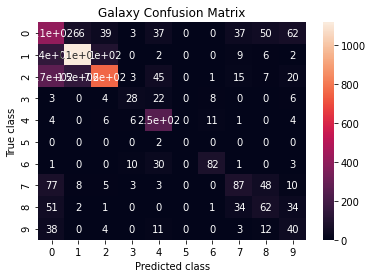

In [52]:
matrix = confusion_matrix(np.argmax(test_labels, axis=1) , np.argmax(pred_y, axis=1))
sns.heatmap(matrix, annot=True)
plt.title('Galaxy Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')

# My Comment: The val_accuracy improved to 0.7002. Class 9 ended up being predicted a bit better. Model 8 did not show improvement. But Model 7 did see some improvement. 

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

# My Comment: I ran out of time so could not finish 

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [53]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

2.8.0


Make a simple autoencoder

In [ ]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

Training ... nn_results/ay250_autoencoder_nn_2022-04-07T02:59.h5
Epoch 1/10
298/469 [==================>...........] - ETA: 19s - loss: 0.0448

In [ ]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?